In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys, os, os.path, time
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.autograd import Variable
from TALNetModel import *
from pslaModels import *
from util_in_multi_h5_unnorm import *
from util_out import *
from util_f1 import *
# from AudioResNet import resnet50
# from AST import ASTModel
from ast_models_original import ASTModel
%matplotlib inline
import subprocess
import pickle

import matplotlib.pyplot as plt
import h5py



In [2]:
curr_node = socket.gethostname().split('.')[0]
batcmd=f"squeue -u billyli | grep {curr_node}"
curr_slurm = subprocess.check_output(batcmd, shell=True, text=True)
slurm_id = curr_slurm.strip().split(' ')[0]
print(slurm_id)

8620457


In [3]:
torch.cuda.is_available()
torch.cuda.device_count()

1

# VICTIM MODEL

In [4]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("--model_type", type=str, default='ast', help="the model used")
parser.add_argument("--dataset", type=str, default="audioset_s", help="the dataset used", choices=["audioset","audioset_s", "esc50", "speechcommands"])
parser.add_argument("--n_mels", type=int, default=128, help="number of mel bins")
parser.add_argument("--dataset-portion", type=str, default='full', help="balance set or full set")
parser.add_argument('--mean', default=-12.7508, type=float, help='normalizing mean')
parser.add_argument('--std', default=11.7584, type=float, help='normalizing std')

parser.add_argument("--exp-dir", type=str, default="", help="directory to dump experiments")
parser.add_argument('--lr', '--learning-rate', default="0.001", type=str, metavar='LR', help='initial learning rate')
parser.add_argument("--optim", type=str, default="adam", help="training optimizer", choices=["sgd", "adam"])
parser.add_argument('-b', '--batch-size', default=12, type=int, metavar='N', help='mini-batch size')
parser.add_argument('-w', '--num-workers', default=32, type=int, metavar='NW', help='# of workers for dataloading (default: 32)')
parser.add_argument("--n-epochs", type=int, default=1, help="number of maximum training epochs")
# not used in the formal experiments
parser.add_argument("--lr_patience", type=int, default=2, help="how many epoch to wait to reduce lr if mAP doesn't improve")

parser.add_argument("--n-print-steps", type=int, default=100, help="number of steps to print statistics")

parser.add_argument('--freqm', help='frequency mask max length', type=int, default=0)
parser.add_argument('--timem', help='time mask max length', type=int, default=0)
parser.add_argument("--mixup", type=float, default=0, help="how many (0-1) samples need to be mixup during training")
parser.add_argument("--bal", type=str, default='bal', help="use balanced sampling or not")
# the stride used in patch spliting, e.g., for patch size 16*16, a stride of 16 means no overlapping, a stride of 10 means overlap of 6.
parser.add_argument("--fstride", type=int, default=8, help="soft split freq stride, overlap=patch_size-stride")
parser.add_argument("--tstride", type=int, default=8, help="soft split time stride, overlap=patch_size-stride")
parser.add_argument('--imagenet_pretrain', help='if use ImageNet pretrained audio spectrogram transformer model', type=bool, default='True')
parser.add_argument('--audioset_pretrain', help='if use ImageNet and audioset pretrained audio spectrogram transformer model', type=bool, default='False')

parser.add_argument('--embedding_size', type = int, default = 1024) # this is the embedding size after a pooling layer
                                                                    # after a non-pooling layer, the embeddings size will be twice this much
parser.add_argument('--n_conv_layers', type = int, default = 10)
parser.add_argument('--n_trans_layers', type = int, default = 2)
parser.add_argument('--kernel_size', type = str, default = '3')     # 'n' or 'nxm'
parser.add_argument('--n_pool_layers', type = int, default = 5)     # the pooling layers will be inserted uniformly into the conv layers
                                                                    # the should be at least 2 and at most 6 pooling layers
                                                                    # the first two pooling layers will have stride (2,2); later ones will have stride (1,2)
parser.add_argument('--batch_norm', type = bool, default = True)
parser.add_argument('--dropout', type = float, default = 0.0)
parser.add_argument('--pooling', type = str, default = 'att', choices = ['max', 'ave', 'lin', 'exp', 'att', 'h-att', 'all'])
parser.add_argument('--continue_from_ckpt', type = str, default = None)
parser.add_argument('--addpos', type = bool, default = True)
parser.add_argument('--transformer_dropout', type = float, default = 0.75)

parser.add_argument("--eff_b", type=int, default=0, help="which efficientnet to use, the larger number, the more complex")
parser.add_argument("--att_head", type=int, default=4, help="number of attention heads")
parser.add_argument("--att_activation", type = str, default = 'sigmoid', choices = ['sigmoid','softmax','relu','linear'])
parser.add_argument('--suffix', type=str, default='')


_StoreAction(option_strings=['--suffix'], dest='suffix', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help=None, metavar=None)

### AST 64x400 best model

In [5]:
args = parser.parse_args(args=['--model_type=resnet','--dataset=audioset_s','--n_mels=64', '--mean=-29.072655','--std=40.71728',
                               '--lr=1.6e-4','--batch-size=188','--n-epochs=10',
                               '--freqm=12','--timem=75','--mixup=0.3',
                               '--transformer_dropout=0.25','--addpos=True','--pooling=att',
                               '--embedding_size=1024', '--att_head=4',
                               '--imagenet_pretrain=True','--suffix=resnet_pretrain-small-feat2-38.2'])
if 'x' not in args.kernel_size:
    args.kernel_size = args.kernel_size + 'x' + args.kernel_size
args.kernel_size = tuple(int(x) for x in args.kernel_size.split('x'))
args.target_length=400
exp_id = f"{args.model_type}-{args.dataset}-{args.dataset_portion}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}\
-fm{args.freqm}-tm{args.timem}-mix{args.mixup}-m{args.mean}-std{args.std}-epoch{args.n_epochs}\
-{args.suffix}"
print(exp_id)
WORKSPACE = '/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp'
MODEL_FILE = os.path.join(WORKSPACE, exp_id, 'models', 'audio_model.4.pth')

resnet-audioset_s-full-pTrue-b188-lr1.6e-4-fm12-tm75-mix0.3-m-29.072655-std40.71728-epoch10-resnet_pretrain-small-feat2-38.2


### AST 128x1024 best model

args = parser.parse_args(args=['--model_type=AST','--dataset=audioset','--n_mels=128', '--mean=-3.6788461','--std=4.3739743',
                               '--lr=1e-5','--batch-size=20','--n-epochs=10','--fstride=10','--tstride=10',
                               '--freqm=36','--timem=192','--mixup=0.3',
                               '--imagenet_pretrain=True','--suffix=ast_challenge-43.0'])
args.target_length=1024
exp_id = f"{args.dataset}-{args.dataset_portion}-f{args.fstride}-t{args.tstride}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}\
-fm{args.freqm}-tm{args.timem}-mix{args.mixup}-m{args.mean}-std{args.std}-epoch{args.n_epochs}-{args.suffix}"
print(exp_id)
WORKSPACE = '/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp'
MODEL_FILE = os.path.join(WORKSPACE, exp_id, 'models', 'audio_model.3.pth')

In [6]:
print(MODEL_FILE)

/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp/resnet-audioset_s-full-pTrue-b188-lr1.6e-4-fm12-tm75-mix0.3-m-29.072655-std40.71728-epoch10-resnet_pretrain-small-feat2-38.2/models/audio_model.4.pth


In [7]:
args

Namespace(addpos=True, att_activation='sigmoid', att_head=4, audioset_pretrain=True, bal='bal', batch_norm=True, batch_size=188, continue_from_ckpt=None, dataset='audioset_s', dataset_portion='full', dropout=0.0, eff_b=0, embedding_size=1024, exp_dir='', freqm=12, fstride=8, imagenet_pretrain=True, kernel_size=(3, 3), lr='1.6e-4', lr_patience=2, mean=-29.072655, mixup=0.3, model_type='resnet', n_conv_layers=10, n_epochs=10, n_mels=64, n_pool_layers=5, n_print_steps=100, n_trans_layers=2, num_workers=32, optim='adam', pooling='att', std=40.71728, suffix='resnet_pretrain-small-feat2-38.2', target_length=400, timem=75, transformer_dropout=0.25, tstride=8)

In [8]:
# Load model
#model = Net(args).cuda()
if args.model_type == 'TAL':
    model = TALNet(args)
elif args.model_type == 'TALtrans':
    model = TransformerEncoder(args)
elif args.model_type == 'TAL-new':
    model = NewNet(args).cuda()
elif args.model_type == 'Trans':
    model = Transformer(args).cuda()
elif args.model_type == 'resnet':
    args.n_class=527
    model = ResNetAttention(args).cuda()
elif args.model_type == 'MMT':
    model = MMTEncoder(args).cuda()
elif args.model_type == 'VM':
    model = videoModel(args).cuda()
elif args.model_type == 'MMTLF':
    model = LateFusion(args).cuda()
elif args.model_type == 'AST':
    model = ASTModel(label_dim=527, fstride=args.fstride, tstride=args.tstride, input_fdim=args.n_mels, input_tdim=args.target_length, imagenet_pretrain=args.imagenet_pretrain, audioset_pretrain=False).cuda()
else:
    print ('model type not recognized')
    exit(0)


Now Use ImageNet Pretrained ResNet50 Model.


In [9]:
optimizer = Adam(model.parameters())

In [10]:
prev_ckpt = torch.load(MODEL_FILE)
# start_ckpt = prev_ckpt['epoch']
# scheduler.load_state_dict(prev_ckpt['scheduler'])
# model = nn.DataParallel(model)
temp = {}
for key, val in prev_ckpt.items():
    key = key.replace('module.','')
    temp[key] = val
model.load_state_dict(temp)
# optimizer.load_state_dict(prev_ckpt['optimizer'])
# write_log('Loading model from %s' % args.continue_from_ckpt)
model.eval()

ResNetAttention(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [11]:
N_CLASSES = 527
N_WORKERS = 6
local = f"/local/slurm-{slurm_id}/local/audio"
if args.dataset == 'audioset_s':
    hf_val_eval_path = os.path.join(local, 'data_64_400_again.h5')
elif args.dataset == 'audioset':
    hf_val_eval_path = os.path.join(local, 'data_128_1024_again.h5')
# hf_val_eval_path = os.path.join(local, 'data_128_1024_strong_cleaned.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

gas_eval_x1, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

In [12]:
gas_eval_x1.shape, gas_eval_y.shape

((20123, 400, 64), (20123, 527))

# Inference

In [13]:
result = []
batch_size =100
x = gas_eval_x1 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#         output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]


total num of batches during testing 202


In [14]:
print(result[0].shape)

(20123, 527)


In [15]:
gas_eval_global_prob_multi = result[0]

In [16]:
# print(gas_eval_global_prob_multi.shape)

In [19]:
import numpy as np
from scipy import stats
from sklearn import metrics
import torch

def d_prime(auc):
    standard_normal = stats.norm()
    d_prime = standard_normal.ppf(auc) * np.sqrt(2.0)
    return d_prime

def calculate_stats(output, target):
    """Calculate statistics including mAP, AUC, etc.
    Args:
      output: 2d array, (samples_num, classes_num)
      target: 2d array, (samples_num, classes_num)
    Returns:
      stats: list of statistic of each class.
    """

    classes_num = target.shape[-1]
    stats = []

    # Accuracy, only used for single-label classification such as esc-50, not for multiple label one such as AudioSet
    acc = metrics.accuracy_score(np.argmax(target, 1), np.argmax(output, 1))

    # Class-wise statistics
    for k in range(classes_num):

        # Average precision
        avg_precision = metrics.average_precision_score(
            target[:, k], output[:, k], average=None)

        # AUC
        auc = metrics.roc_auc_score(target[:, k], output[:, k], average=None)

        # Precisions, recalls
        (precisions, recalls, thresholds) = metrics.precision_recall_curve(
            target[:, k], output[:, k])

        # FPR, TPR
        (fpr, tpr, thresholds) = metrics.roc_curve(target[:, k], output[:, k])

        save_every_steps = 1000     # Sample statistics to reduce size
        dict = {'precisions': precisions[0::save_every_steps],
                'recalls': recalls[0::save_every_steps],
                'AP': avg_precision,
                'fpr': fpr[0::save_every_steps],
                'fnr': 1. - tpr[0::save_every_steps],
                'auc': auc,
                # note acc is not class-wise, this is just to keep consistent with other metrics
                'acc': acc
                }
        stats.append(dict)

    return stats

In [20]:
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 

In [21]:
print(gas_eval_global_prob_multi,'max:', np.max(gas_eval_global_prob_multi), 'min: ', np.min(gas_eval_global_prob_multi))

[[3.1866725e-03 3.1364255e-04 2.7972818e-04 ... 1.3833094e-04
  5.9575330e-05 5.6786572e-05]
 [7.1989381e-01 2.3246941e-04 3.3415694e-05 ... 3.3217822e-03
  3.1671582e-03 3.4138406e-04]
 [1.1844827e-02 7.8637875e-04 4.1167400e-04 ... 1.6693654e-04
  8.3817271e-05 5.4945303e-06]
 ...
 [1.2719901e-01 4.8621828e-03 3.0500987e-03 ... 1.5490938e-03
  3.3335257e-03 1.3650476e-03]
 [1.6859972e-03 9.4950752e-05 9.8940931e-05 ... 8.7613356e-04
  9.9974126e-04 4.3370153e-05]
 [5.0702728e-03 5.5816351e-03 3.2334623e-04 ... 2.8834923e-04
  1.0017094e-04 5.7029666e-04]] max: 0.99995995 min:  4.784873e-13


In [22]:
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print(mAP)
print(mAUC)
print(dprime_val)

0.3823184773665582
0.9656050635531493
2.573582079758978


In [17]:
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)

Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------


In [18]:
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

0.3823184773665582 0.9656050635531495 2.5735820797589803
 Average | 0.382 | 0.966 | 2.574 
---------+-------+-------+-------
       0 | 0.778 | 0.927 | 2.061 
       1 | 0.079 | 0.829 | 1.346 
       2 | 0.122 | 0.933 | 2.123 
       3 | 0.393 | 0.968 | 2.613 
       4 | 0.232 | 0.973 | 2.734 
       5 | 0.060 | 0.940 | 2.196 
       6 | 0.488 | 0.997 | 3.814 
       7 | 0.432 | 0.983 | 3.009 
       8 | 0.140 | 0.945 | 2.259 
       9 | 0.117 | 0.947 | 2.282 
      10 | 0.142 | 0.970 | 2.659 
      11 | 0.186 | 0.978 | 2.846 
      12 | 0.845 | 0.999 | 4.613 
      13 | 0.510 | 0.995 | 3.692 
      14 | 0.257 | 0.983 | 3.007 
      15 | 0.800 | 0.996 | 3.776 
      16 | 0.420 | 0.978 | 2.862 
      17 | 0.612 | 0.995 | 3.612 
      18 | 0.219 | 0.980 | 2.907 
      19 | 0.231 | 0.974 | 2.745 
      20 | 0.402 | 0.992 | 3.402 
      21 | 0.213 | 0.971 | 2.675 
      22 | 0.425 | 0.987 | 3.130 
      23 | 0.467 | 0.981 | 2.929 
      24 | 0.266 | 0.973 | 2.731 
      25 | 0.156 | 0.894 

# Occlusion

In [19]:
gas_eval_x1_origin = gas_eval_x1

In [20]:
min_val = numpy.min(gas_eval_x1)
max_val = numpy.max(gas_eval_x1)
mean_val = numpy.mean(gas_eval_x1)
std_val = numpy.std(gas_eval_x1)
print(min_val, max_val, mean_val, std_val)

-2.0989532 1.3362997 -0.123829365 0.5745247


In [21]:
gas_eval_x1.shape

(20123, 400, 64)

<h>Occ 4s</h>

In [22]:
new_gas_eval = []
time_frame = 400
step = 80
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

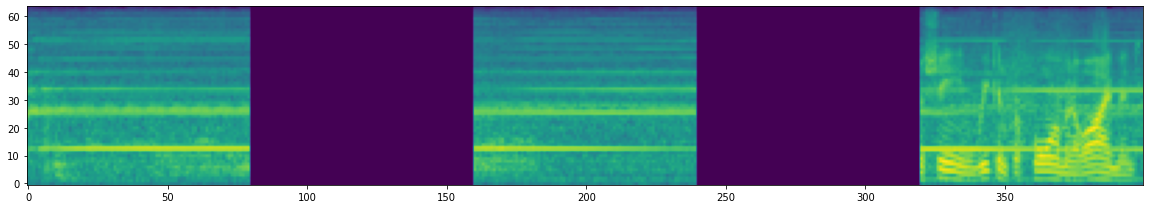

In [23]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [24]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#         output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.3132535490741845 0.9514922493944972 2.346884452754313
 Average | 0.313 | 0.951 | 2.347 
---------+-------+-------+-------
       0 | 0.727 | 0.905 | 1.853 
       1 | 0.059 | 0.835 | 1.379 
       2 | 0.117 | 0.931 | 2.097 
       3 | 0.342 | 0.953 | 2.371 
       4 | 0.122 | 0.972 | 2.700 
       5 | 0.049 | 0.943 | 2.239 
       6 | 0.418 | 0.994 | 3.523 
       7 | 0.331 | 0.979 | 2.888 
       8 | 0.103 | 0.937 | 2.160 
       9 | 0.112 | 0.933 | 2.125 
      10 | 0.070 | 0.952 | 2.361 
      11 | 0.157 | 0.971 | 2.674 
      12 | 0.777 | 0.988 | 3.176 
      13 | 0.401 | 0.992 | 3.400 
      14 | 0.190 | 0.962 | 2.511 
      15 | 0.727 | 0.983 | 2.983 
      16 | 0.352 | 0.974 | 2.740 
      17 | 0.515 | 0.994 | 3.539 
      18 | 0.196 | 0.965 | 2.563 
      19 | 0.157 | 0.962 | 2.516 
      20 | 0.252 | 0.979 | 2.876 
      21 | 0.174 | 0.

<h>First 5s</h>

In [25]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[:200]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

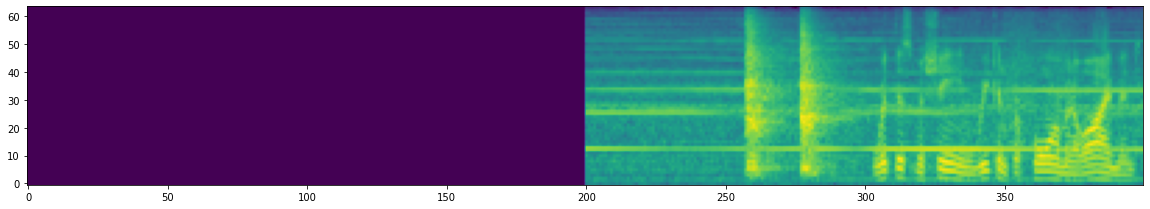

In [26]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [27]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.2960858072435589 0.9401998754492109 2.201157902920926
 Average | 0.296 | 0.940 | 2.201 
---------+-------+-------+-------
       0 | 0.699 | 0.874 | 1.619 
       1 | 0.061 | 0.816 | 1.271 
       2 | 0.091 | 0.909 | 1.887 
       3 | 0.321 | 0.935 | 2.145 
       4 | 0.109 | 0.937 | 2.166 
       5 | 0.033 | 0.934 | 2.132 
       6 | 0.323 | 0.968 | 2.624 
       7 | 0.296 | 0.977 | 2.833 
       8 | 0.096 | 0.920 | 1.990 
       9 | 0.102 | 0.933 | 2.123 
      10 | 0.052 | 0.935 | 2.145 
      11 | 0.125 | 0.952 | 2.348 
      12 | 0.694 | 0.982 | 2.961 
      13 | 0.371 | 0.989 | 3.224 
      14 | 0.177 | 0.956 | 2.406 
      15 | 0.590 | 0.953 | 2.372 
      16 | 0.365 | 0.966 | 2.577 
      17 | 0.476 | 0.982 | 2.968 
      18 | 0.109 | 0.946 | 2.273 
      19 | 0.186 | 0.949 | 2.309 
      20 | 0.347 | 0.972 | 2.712 
      21 | 0.171 | 0.

<h>mid 5s</h>

In [28]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[100:300]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

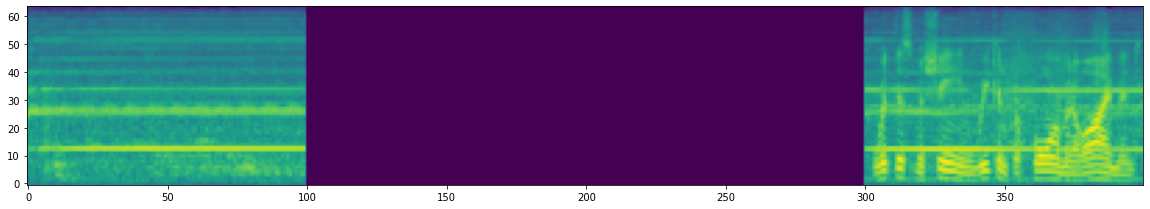

In [29]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [30]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.2989580619855406 0.9468521510153074 2.28405284538705
 Average | 0.299 | 0.947 | 2.284 
---------+-------+-------+-------
       0 | 0.715 | 0.895 | 1.769 
       1 | 0.039 | 0.830 | 1.349 
       2 | 0.089 | 0.935 | 2.139 
       3 | 0.290 | 0.949 | 2.317 
       4 | 0.140 | 0.963 | 2.534 
       5 | 0.056 | 0.926 | 2.043 
       6 | 0.365 | 0.985 | 3.067 
       7 | 0.345 | 0.977 | 2.831 
       8 | 0.091 | 0.925 | 2.036 
       9 | 0.090 | 0.938 | 2.178 
      10 | 0.056 | 0.943 | 2.240 
      11 | 0.110 | 0.962 | 2.513 
      12 | 0.726 | 0.991 | 3.345 
      13 | 0.370 | 0.992 | 3.415 
      14 | 0.123 | 0.958 | 2.437 
      15 | 0.719 | 0.976 | 2.803 
      16 | 0.350 | 0.958 | 2.447 
      17 | 0.516 | 0.982 | 2.972 
      18 | 0.268 | 0.946 | 2.268 
      19 | 0.164 | 0.960 | 2.483 
      20 | 0.260 | 0.978 | 2.855 
      21 | 0.158 | 0.9

<h>mid 5s</h>

In [31]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[200:400]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

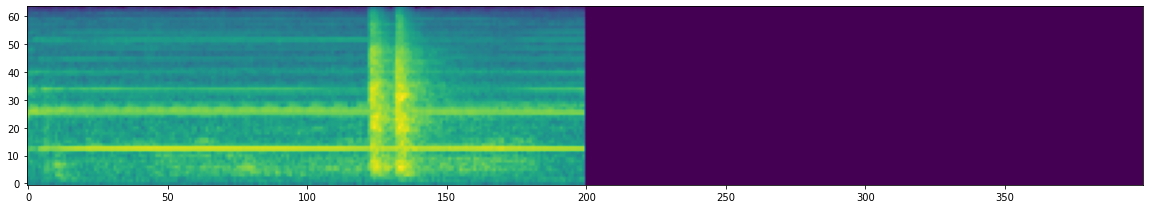

In [32]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [33]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.30133020153456175 0.9397132189568943 2.195383626409907
 Average | 0.301 | 0.940 | 2.195 
---------+-------+-------+-------
       0 | 0.704 | 0.875 | 1.630 
       1 | 0.024 | 0.829 | 1.345 
       2 | 0.094 | 0.879 | 1.653 
       3 | 0.270 | 0.944 | 2.253 
       4 | 0.160 | 0.953 | 2.373 
       5 | 0.034 | 0.910 | 1.895 
       6 | 0.359 | 0.977 | 2.827 
       7 | 0.266 | 0.970 | 2.664 
       8 | 0.133 | 0.925 | 2.031 
       9 | 0.098 | 0.916 | 1.949 
      10 | 0.094 | 0.930 | 2.088 
      11 | 0.137 | 0.956 | 2.419 
      12 | 0.770 | 0.998 | 4.142 
      13 | 0.328 | 0.972 | 2.709 
      14 | 0.131 | 0.935 | 2.145 
      15 | 0.760 | 0.986 | 3.125 
      16 | 0.345 | 0.950 | 2.328 
      17 | 0.524 | 0.981 | 2.934 
      18 | 0.194 | 0.964 | 2.536 
      19 | 0.205 | 0.947 | 2.286 
      20 | 0.259 | 0.959 | 2.460 
      21 | 0.131 | 0

<h>Every 1s</h1>

In [34]:
new_gas_eval = []
time_frame = 400
step = 40
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

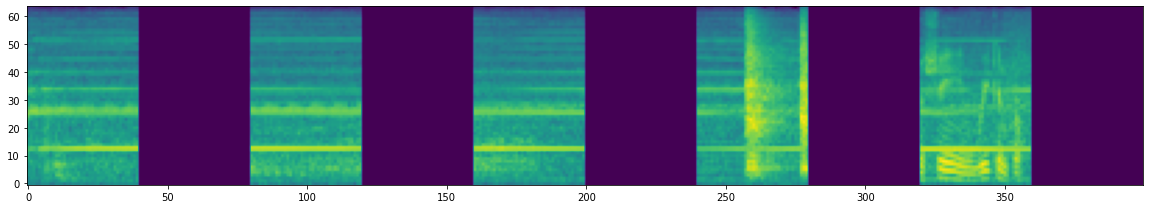

In [35]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [36]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.23742503820556168 0.9292551166723713 2.07926990334202
 Average | 0.237 | 0.929 | 2.079 
---------+-------+-------+-------
       0 | 0.685 | 0.883 | 1.680 
       1 | 0.044 | 0.820 | 1.297 
       2 | 0.092 | 0.909 | 1.885 
       3 | 0.249 | 0.936 | 2.147 
       4 | 0.122 | 0.958 | 2.444 
       5 | 0.034 | 0.926 | 2.045 
       6 | 0.319 | 0.984 | 3.029 
       7 | 0.241 | 0.974 | 2.743 
       8 | 0.101 | 0.899 | 1.807 
       9 | 0.085 | 0.921 | 1.995 
      10 | 0.054 | 0.948 | 2.293 
      11 | 0.151 | 0.949 | 2.311 
      12 | 0.690 | 0.981 | 2.948 
      13 | 0.221 | 0.978 | 2.843 
      14 | 0.081 | 0.934 | 2.128 
      15 | 0.680 | 0.979 | 2.882 
      16 | 0.365 | 0.963 | 2.531 
      17 | 0.322 | 0.974 | 2.741 
      18 | 0.132 | 0.952 | 2.350 
      19 | 0.170 | 0.947 | 2.291 
      20 | 0.195 | 0.956 | 2.418 
      21 | 0.113 | 0.

<h>Every 0.5s</h1>

In [37]:
new_gas_eval = []
time_frame = 400
step = 20
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

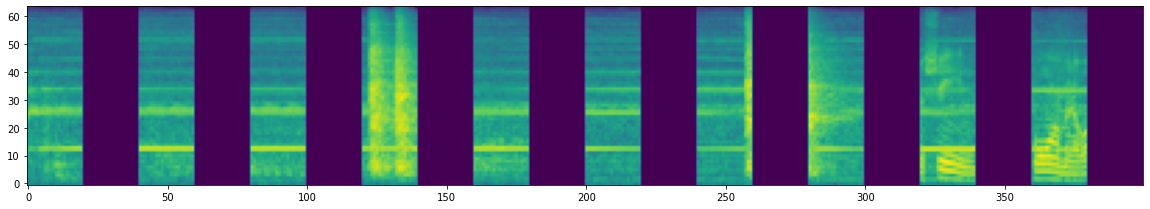

In [38]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [39]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.13010846419079886 0.8847397580909104 1.6956692002869362
 Average | 0.130 | 0.885 | 1.696 
---------+-------+-------+-------
       0 | 0.637 | 0.859 | 1.523 
       1 | 0.011 | 0.798 | 1.179 
       2 | 0.064 | 0.909 | 1.884 
       3 | 0.176 | 0.922 | 2.010 
       4 | 0.088 | 0.951 | 2.333 
       5 | 0.128 | 0.935 | 2.144 
       6 | 0.166 | 0.979 | 2.869 
       7 | 0.220 | 0.972 | 2.692 
       8 | 0.023 | 0.873 | 1.612 
       9 | 0.055 | 0.841 | 1.410 
      10 | 0.033 | 0.865 | 1.563 
      11 | 0.020 | 0.892 | 1.746 
      12 | 0.365 | 0.941 | 2.211 
      13 | 0.074 | 0.916 | 1.946 
      14 | 0.059 | 0.917 | 1.956 
      15 | 0.556 | 0.970 | 2.664 
      16 | 0.265 | 0.958 | 2.437 
      17 | 0.169 | 0.960 | 2.481 
      18 | 0.137 | 0.952 | 2.353 
      19 | 0.103 | 0.933 | 2.119 
      20 | 0.229 | 0.966 | 2.582 
      21 | 0.055 | 

<h>Every 0.25s</h1>

In [40]:
new_gas_eval = []
time_frame = 400
step = 10
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

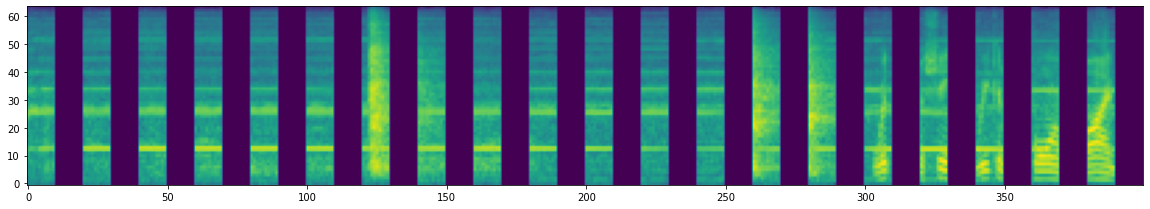

In [41]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [42]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.019798976270885036 0.6365269911083383 0.493830468420194
 Average | 0.020 | 0.637 | 0.494 
---------+-------+-------+-------
       0 | 0.447 | 0.685 | 0.683 
       1 | 0.003 | 0.513 | 0.045 
       2 | 0.006 | 0.544 | 0.156 
       3 | 0.023 | 0.584 | 0.302 
       4 | 0.006 | 0.526 | 0.092 
       5 | 0.008 | 0.686 | 0.687 
       6 | 0.004 | 0.502 | 0.008 
       7 | 0.019 | 0.759 | 0.995 
       8 | 0.013 | 0.475 |-0.089 
       9 | 0.004 | 0.475 |-0.089 
      10 | 0.005 | 0.594 | 0.336 
      11 | 0.003 | 0.505 | 0.017 
      12 | 0.002 | 0.309 |-0.707 
      13 | 0.003 | 0.416 |-0.298 
      14 | 0.003 | 0.481 |-0.067 
      15 | 0.208 | 0.925 | 2.032 
      16 | 0.008 | 0.544 | 0.156 
      17 | 0.002 | 0.380 |-0.432 
      18 | 0.004 | 0.542 | 0.148 
      19 | 0.003 | 0.518 | 0.065 
      20 | 0.003 | 0.406 |-0.335 
      21 | 0.003 | 

<h>Every 0.25s</h1>

In [43]:
new_gas_eval = []
time_frame = 400
step = 5
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

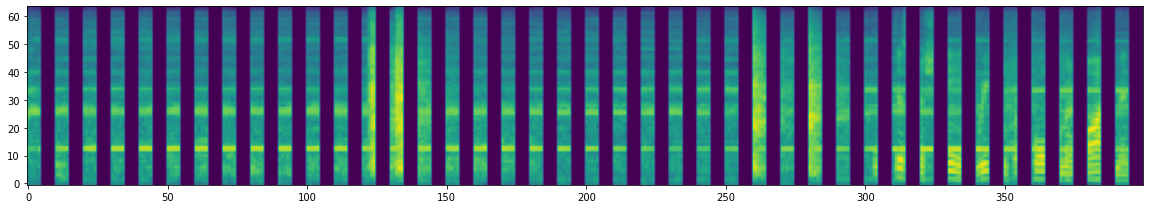

In [44]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [45]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.014387796785980197 0.6088954329742983 0.39094704527241564
 Average | 0.014 | 0.609 | 0.391 
---------+-------+-------+-------
       0 | 0.297 | 0.557 | 0.203 
       1 | 0.003 | 0.508 | 0.027 
       2 | 0.005 | 0.589 | 0.319 
       3 | 0.009 | 0.448 |-0.184 
       4 | 0.004 | 0.565 | 0.230 
       5 | 0.011 | 0.577 | 0.275 
       6 | 0.003 | 0.442 |-0.208 
       7 | 0.003 | 0.547 | 0.168 
       8 | 0.005 | 0.664 | 0.599 
       9 | 0.006 | 0.680 | 0.660 
      10 | 0.013 | 0.718 | 0.814 
      11 | 0.003 | 0.592 | 0.331 
      12 | 0.005 | 0.664 | 0.599 
      13 | 0.006 | 0.733 | 0.881 
      14 | 0.004 | 0.596 | 0.344 
      15 | 0.108 | 0.915 | 1.945 
      16 | 0.005 | 0.467 |-0.116 
      17 | 0.003 | 0.397 |-0.369 
      18 | 0.003 | 0.472 |-0.099 
      19 | 0.015 | 0.657 | 0.571 
      20 | 0.003 | 0.455 |-0.159 
      21 | 0.004 

<h>concat 0.125s</h>

In [46]:
new_gas_eval = []
time_frame = 400
step = 5
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

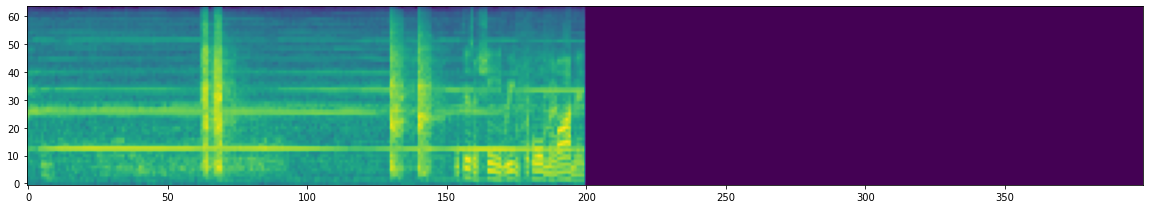

In [47]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [48]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.2664361367603543 0.9400414841358281 2.1992745319732023
 Average | 0.266 | 0.940 | 2.199 
---------+-------+-------+-------
       0 | 0.681 | 0.887 | 1.711 
       1 | 0.038 | 0.838 | 1.394 
       2 | 0.085 | 0.904 | 1.847 
       3 | 0.245 | 0.950 | 2.322 
       4 | 0.131 | 0.964 | 2.545 
       5 | 0.032 | 0.915 | 1.941 
       6 | 0.259 | 0.986 | 3.127 
       7 | 0.269 | 0.974 | 2.743 
       8 | 0.111 | 0.915 | 1.943 
       9 | 0.073 | 0.900 | 1.814 
      10 | 0.052 | 0.918 | 1.966 
      11 | 0.151 | 0.946 | 2.276 
      12 | 0.707 | 0.992 | 3.430 
      13 | 0.384 | 0.989 | 3.228 
      14 | 0.191 | 0.948 | 2.302 
      15 | 0.674 | 0.985 | 3.078 
      16 | 0.289 | 0.961 | 2.485 
      17 | 0.471 | 0.990 | 3.304 
      18 | 0.105 | 0.951 | 2.335 
      19 | 0.130 | 0.942 | 2.222 
      20 | 0.243 | 0.968 | 2.629 
      21 | 0.177 | 0

<h>concat 0.25s</h>

In [49]:
new_gas_eval = []
time_frame = 400
step = 10
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

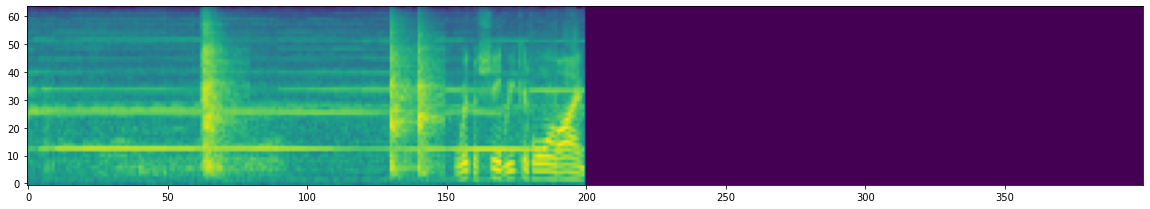

In [50]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [51]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.2770187017176906 0.9430365458742272 2.235569423454312
 Average | 0.277 | 0.943 | 2.236 
---------+-------+-------+-------
       0 | 0.696 | 0.893 | 1.755 
       1 | 0.040 | 0.820 | 1.294 
       2 | 0.090 | 0.910 | 1.895 
       3 | 0.240 | 0.953 | 2.375 
       4 | 0.180 | 0.957 | 2.422 
       5 | 0.068 | 0.922 | 2.004 
       6 | 0.281 | 0.984 | 3.038 
       7 | 0.289 | 0.971 | 2.679 
       8 | 0.125 | 0.907 | 1.874 
       9 | 0.094 | 0.917 | 1.962 
      10 | 0.057 | 0.927 | 2.053 
      11 | 0.131 | 0.943 | 2.232 
      12 | 0.799 | 0.998 | 4.048 
      13 | 0.438 | 0.988 | 3.196 
      14 | 0.182 | 0.951 | 2.343 
      15 | 0.655 | 0.992 | 3.382 
      16 | 0.318 | 0.964 | 2.547 
      17 | 0.502 | 0.989 | 3.231 
      18 | 0.131 | 0.968 | 2.611 
      19 | 0.167 | 0.962 | 2.504 
      20 | 0.204 | 0.979 | 2.872 
      21 | 0.167 | 0.

<h>concat 0.5s</h>

In [52]:
new_gas_eval = []
time_frame = 400
step = 20
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

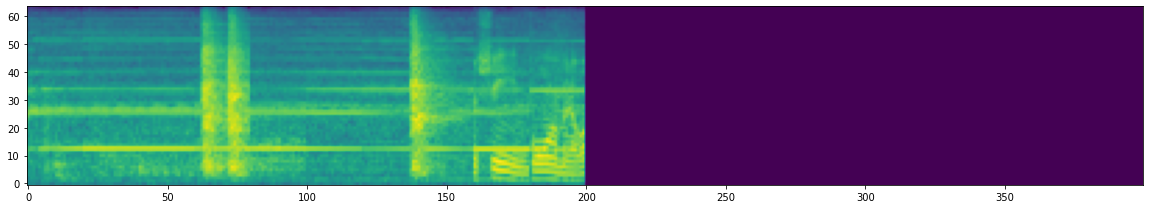

In [53]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [54]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.2936516639853805 0.9468830269348134 2.2844562513489515
 Average | 0.294 | 0.947 | 2.284 
---------+-------+-------+-------
       0 | 0.703 | 0.895 | 1.773 
       1 | 0.037 | 0.822 | 1.307 
       2 | 0.110 | 0.936 | 2.158 
       3 | 0.277 | 0.951 | 2.341 
       4 | 0.137 | 0.965 | 2.568 
       5 | 0.059 | 0.930 | 2.083 
       6 | 0.257 | 0.984 | 3.019 
       7 | 0.372 | 0.985 | 3.061 
       8 | 0.097 | 0.923 | 2.017 
       9 | 0.124 | 0.930 | 2.082 
      10 | 0.050 | 0.918 | 1.970 
      11 | 0.127 | 0.956 | 2.406 
      12 | 0.692 | 0.997 | 3.876 
      13 | 0.436 | 0.987 | 3.152 
      14 | 0.189 | 0.949 | 2.312 
      15 | 0.697 | 0.997 | 3.820 
      16 | 0.297 | 0.969 | 2.634 
      17 | 0.477 | 0.985 | 3.063 
      18 | 0.108 | 0.965 | 2.559 
      19 | 0.169 | 0.948 | 2.297 
      20 | 0.190 | 0.983 | 3.012 
      21 | 0.146 | 0

<h>concat 1s</h>

In [55]:
new_gas_eval = []
time_frame = 400
step = 40
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

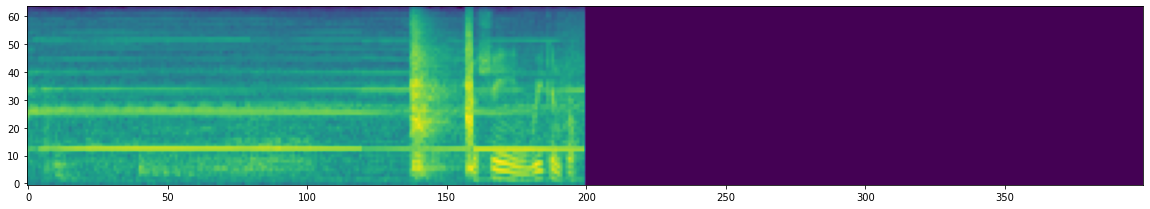

In [56]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [57]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.30208183613643386 0.948048969811475 2.2998277172893506
 Average | 0.302 | 0.948 | 2.300 
---------+-------+-------+-------
       0 | 0.709 | 0.896 | 1.780 
       1 | 0.053 | 0.822 | 1.305 
       2 | 0.089 | 0.907 | 1.874 
       3 | 0.271 | 0.952 | 2.357 
       4 | 0.196 | 0.970 | 2.657 
       5 | 0.084 | 0.914 | 1.929 
       6 | 0.295 | 0.985 | 3.073 
       7 | 0.347 | 0.955 | 2.390 
       8 | 0.093 | 0.922 | 2.011 
       9 | 0.131 | 0.936 | 2.156 
      10 | 0.063 | 0.949 | 2.318 
      11 | 0.133 | 0.952 | 2.354 
      12 | 0.730 | 0.998 | 3.992 
      13 | 0.358 | 0.989 | 3.227 
      14 | 0.157 | 0.952 | 2.355 
      15 | 0.738 | 0.991 | 3.324 
      16 | 0.358 | 0.974 | 2.755 
      17 | 0.345 | 0.988 | 3.172 
      18 | 0.135 | 0.969 | 2.635 
      19 | 0.205 | 0.950 | 2.326 
      20 | 0.272 | 0.980 | 2.917 
      21 | 0.124 | 0

# White noise 2D

In [35]:
import numpy as np
new_gas_eval = []
for record in gas_eval_x1:
    record += np.random.normal(0, 0.1, (400,64))
    new_gas_eval.append(record)
new_gas_eval = numpy.array(new_gas_eval)

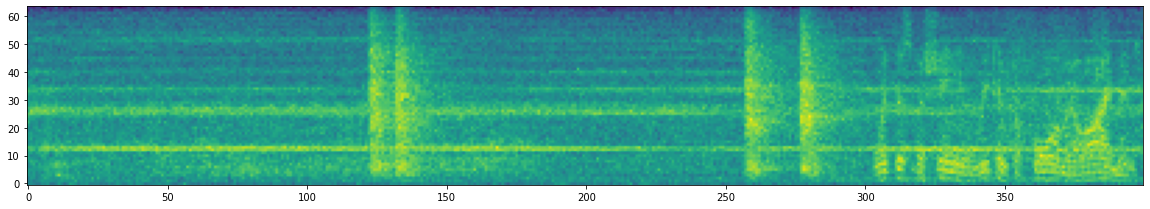

In [36]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [38]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#         output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.1660572520069402 0.8812910778125327 1.6708445571708912
 Average | 0.166 | 0.881 | 1.671 
---------+-------+-------+-------
       0 | 0.685 | 0.887 | 1.715 
       1 | 0.023 | 0.789 | 1.135 
       2 | 0.106 | 0.921 | 1.994 
       3 | 0.265 | 0.936 | 2.149 
       4 | 0.235 | 0.970 | 2.660 
       5 | 0.049 | 0.938 | 2.174 
       6 | 0.214 | 0.970 | 2.655 
       7 | 0.389 | 0.987 | 3.155 
       8 | 0.021 | 0.819 | 1.289 
       9 | 0.022 | 0.845 | 1.434 
      10 | 0.049 | 0.839 | 1.403 
      11 | 0.010 | 0.695 | 0.719 
      12 | 0.437 | 0.927 | 2.060 
      13 | 0.199 | 0.930 | 2.092 
      14 | 0.112 | 0.925 | 2.034 
      15 | 0.547 | 0.977 | 2.825 
      16 | 0.329 | 0.954 | 2.376 
      17 | 0.504 | 0.990 | 3.286 
      18 | 0.110 | 0.958 | 2.451 
      19 | 0.156 | 0.955 | 2.398 
      20 | 0.321 | 0.983 | 3.008 
      21 | 0.118 | 0

# Adversarial Perturbation

In [49]:
from torch.cuda.amp import autocast,GradScaler

In [50]:
import numpy as np
np.unique(gas_eval_y.astype('float16'))
print(np.min(gas_eval_x1), np.max(gas_eval_x1))

-2.6366315 1.6732323


In [51]:
pgd_dataset = torch.utils.data.TensorDataset(torch.from_numpy(gas_eval_x1[:]), torch.from_numpy(gas_eval_y[:].astype('float32')))
pgd_dataloader = torch.utils.data.DataLoader(pgd_dataset, batch_size=50, shuffle=True)

In [52]:
def pgd(model, dataloader, delta_global, num_steps, step_size, step_norm, eps, eps_norm, x_min, x_max, delta_min, delta_max, y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    model.cuda().eval()
    targeted = y_target is not None
    criterion = nn.BCELoss().cuda()
    loss_global = 0
    for epoch in range(num_steps):
        torch.cuda.empty_cache()
        loss_global = 0
        dataiter = iter(dataloader)
        for step, (feat_a, y) in enumerate(dataiter):
            feat_a = feat_a.cuda()
            
            x_adv_1 = feat_a + delta_global #.to(x.device)
            x_adv_1 = x_adv_1.clamp(x_min, x_max)
            # only video
           
            N_1, T_1, V_1 = x_adv_1.shape
#             print(N_1,T_1,V_1)

            #######   data loaded ###################
            _x_adv_1 = x_adv_1.clone().detach().requires_grad_(True).cuda()

            #######   get gradient #################
#             with torch.no_grad():
#             model.train()# double check

            out = model(_x_adv_1)
#                 print(out)
#                 out = torch.sigmoid(out)
#                 epsilon = 1e-7
#                 out = torch.clamp(out, epsilon, 1. - epsilon)
#                 temp_out = out.clamp(0,1).cuda()
#                 print(temp_out.shape, y.shape, temp_out.max(), temp_out.min())
#                 print(temp_out.shape, y.shape)

            loss = criterion(out, y.to('cuda', non_blocking=True))
            loss_global += loss.item()
#                 print(loss.item(), loss_global)
            loss.backward()
#             break
            ########   updated _x_adv ###############
            with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
                if step_norm == 'inf':
                    gradients = _x_adv_1.grad.sign() * step_size
                else:
                    # The grad is normalized here.
                    # gradients = _x_adv.grad 
                    # Only normalize w.r.t. to feats at a timestep
                    gradients = _x_adv_1.grad/_x_adv_1.grad.norm(step_norm, dim=-1).view(-1, T_1, 1)
                    gradients *= step_size
                if targeted:
                    # Targeted: Gradient descent with on the loss of the (incorrect) target label
                    # w.r.t. the image data
                    x_adv_1 -= gradients
                else:
                    # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                    # the model parameters
                    x_adv_1 += gradients
            # Project back into l_norm ball and correct range
            if eps_norm == 'inf':
                # Workaround as PyTorch doesn't have elementwise clip
                x_adv_1 = torch.max(torch.min(x_adv_1, feat_a + eps), feat_a - eps)
                delta = x_adv_1 - feat_a
            else:
                delta = x_adv_1 - feat_a
            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            # 100 10 2048
#             print(delta)
            mask = delta.view(delta.shape[0], -1).norm(float(eps_norm), dim=1) <= eps #100*(20480) => 100
            scaling_factor = delta.view(delta.shape[0], T_1, -1).norm(float(eps_norm), dim=-1) #100 10 2048 => 100 40
            scaling_factor[mask] = eps
#             print(scaling_factor)
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / (scaling_factor+1e-7).view(-1, T_1, 1)
#             print(delta)
#             return delta
            delta = delta.float()
            delta = torch.mean(delta,0)
#             print(delta)
            delta_global += delta * N_1 / 20123
            delta_global = delta_global.clamp(delta_min, delta_max)
#             print(delta_global)
            for name, param in model.named_parameters():
                if param.requires_grad:
                    try:
                        param.grad.zero_()
                    except:
                        pass
        print(f'global loss:{loss_global}')
    return delta_global

In [53]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, torch.zeros((400,64)).cuda(), num_steps=20, step_size=0.01, step_norm='inf', eps= 0.1, eps_norm='inf', x_min=np.min(gas_eval_x1), x_max=np.max(gas_eval_x1), delta_min = torch.tensor(np.min(gas_eval_x1) - np.min(gas_eval_x1,axis=0)).cuda(), delta_max = torch.tensor(np.max(gas_eval_x1) - np.max(gas_eval_x1,axis=0)).cuda(), y_target=None )

global loss:9.864313323050737
global loss:9.871652817353606
global loss:9.898152273148298
global loss:9.973393805325031
global loss:10.217052202671766
global loss:11.49536145478487
global loss:14.666802611202002
global loss:17.96019598469138
global loss:19.692030787467957
global loss:20.418537627905607
global loss:20.51645301282406
global loss:20.279501143842936
global loss:20.044293347746134
global loss:19.92984976246953
global loss:19.888708911836147
global loss:19.886322431266308
global loss:19.893985141068697
global loss:19.898363552987576
global loss:19.901233486831188
global loss:19.90074483677745


In [59]:
new_gas_eval = perturb.cpu().numpy() + gas_eval_x1

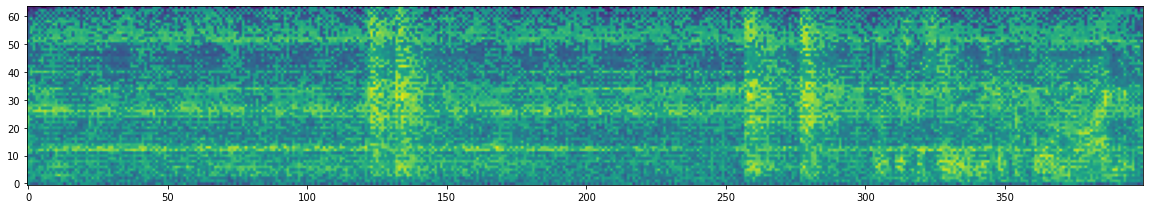

In [60]:

plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [61]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.01112737894129746 0.5415575401298098 0.14758509067948675
 Average | 0.011 | 0.542 | 0.148 
---------+-------+-------+-------
       0 | 0.356 | 0.626 | 0.455 
       1 | 0.003 | 0.428 |-0.258 
       2 | 0.005 | 0.603 | 0.371 
       3 | 0.013 | 0.586 | 0.307 
       4 | 0.006 | 0.697 | 0.728 
       5 | 0.004 | 0.591 | 0.327 
       6 | 0.005 | 0.671 | 0.626 
       7 | 0.006 | 0.627 | 0.457 
       8 | 0.003 | 0.523 | 0.082 
       9 | 0.004 | 0.594 | 0.336 
      10 | 0.006 | 0.707 | 0.768 
      11 | 0.003 | 0.559 | 0.210 
      12 | 0.004 | 0.644 | 0.521 
      13 | 0.002 | 0.359 |-0.511 
      14 | 0.004 | 0.631 | 0.472 
      15 | 0.043 | 0.955 | 2.403 
      16 | 0.005 | 0.496 |-0.013 
      17 | 0.003 | 0.445 |-0.194 
      18 | 0.003 | 0.509 | 0.033 
      19 | 0.003 | 0.492 |-0.027 
      20 | 0.003 | 0.517 | 0.061 
      21 | 0.003 |

In [62]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, torch.zeros((400,64)).cuda(), num_steps=20, step_size=0.01, step_norm=2, eps= 0.1, eps_norm=2, x_min=np.min(gas_eval_x1), x_max=np.max(gas_eval_x1), delta_min = torch.tensor(np.min(gas_eval_x1) - np.min(gas_eval_x1,axis=0)).cuda(), delta_max = torch.tensor(np.max(gas_eval_x1) - np.max(gas_eval_x1,axis=0)).cuda(), y_target=None )

global loss:9.911004144698381
global loss:10.290676578879356
global loss:10.827555345371366
global loss:11.475067298859358
global loss:12.19289088808
global loss:12.928475230932236
global loss:13.62256115861237
global loss:14.272683272138238
global loss:14.853409428149462
global loss:15.379298385232687
global loss:15.83757046237588
global loss:16.242404287680984
global loss:16.57996068894863
global loss:16.880549628287554
global loss:17.137604855000973
global loss:17.36193346604705
global loss:17.563275456428528
global loss:17.729031819850206
global loss:17.879881970584393
global loss:17.991252291947603


In [63]:
new_gas_eval = perturb.cpu().numpy() + gas_eval_x1

In [64]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.024720042471939277 0.6076874261622212 0.38649990733883666
 Average | 0.025 | 0.608 | 0.386 
---------+-------+-------+-------
       0 | 0.543 | 0.773 | 1.059 
       1 | 0.003 | 0.487 |-0.044 
       2 | 0.022 | 0.722 | 0.832 
       3 | 0.060 | 0.733 | 0.880 
       4 | 0.057 | 0.845 | 1.438 
       5 | 0.074 | 0.807 | 1.226 
       6 | 0.005 | 0.685 | 0.680 
       7 | 0.154 | 0.847 | 1.448 
       8 | 0.003 | 0.509 | 0.031 
       9 | 0.003 | 0.444 |-0.198 
      10 | 0.004 | 0.524 | 0.087 
      11 | 0.002 | 0.347 |-0.558 
      12 | 0.003 | 0.461 |-0.139 
      13 | 0.002 | 0.306 |-0.718 
      14 | 0.007 | 0.595 | 0.338 
      15 | 0.024 | 0.898 | 1.799 
      16 | 0.007 | 0.570 | 0.250 
      17 | 0.004 | 0.559 | 0.211 
      18 | 0.004 | 0.597 | 0.349 
      19 | 0.004 | 0.569 | 0.248 
      20 | 0.004 | 0.593 | 0.333 
      21 | 0.003 

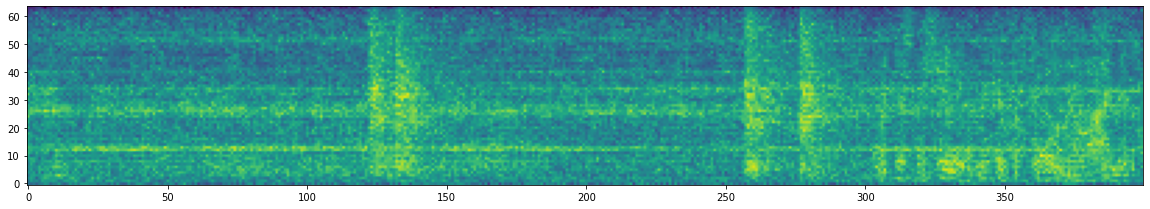

In [65]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

# Strong Label Masking

In [22]:
hf_val_eval_path = os.path.join(local, 'data_64_400_strong_corrected.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

strong_eval_x1, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

In [41]:
result = []
batch_size =100
x = strong_eval_x1 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#         output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]

total num of batches during testing 202


In [42]:
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.18316014496105668 0.8260766407501565 1.3276271214663165
 Average | 0.183 | 0.826 | 1.328 
---------+-------+-------+-------
       0 | 0.598 | 0.786 | 1.122 
       1 | 0.020 | 0.639 | 0.502 
       2 | 0.015 | 0.744 | 0.928 
       3 | 0.176 | 0.840 | 1.408 
       4 | 0.104 | 0.802 | 1.202 
       5 | 0.026 | 0.789 | 1.133 
       6 | 0.241 | 0.921 | 1.997 
       7 | 0.183 | 0.866 | 1.566 
       8 | 0.045 | 0.810 | 1.241 
       9 | 0.046 | 0.812 | 1.253 
      10 | 0.089 | 0.839 | 1.399 
      11 | 0.045 | 0.822 | 1.306 
      12 | 0.249 | 0.807 | 1.225 
      13 | 0.078 | 0.778 | 1.084 
      14 | 0.129 | 0.919 | 1.976 
      15 | 0.375 | 0.939 | 2.192 
      16 | 0.220 | 0.888 | 1.722 
      17 | 0.224 | 0.939 | 2.189 
      18 | 0.128 | 0.929 | 2.081 
      19 | 0.190 | 0.948 | 2.304 
      20 | 0.317 | 0.914 | 1.934 
      21 | 0.068 | 0.860 | 1.530 
      22 | 0.334 | 0.899 

# Gaussian Noise Correct from WAV


In [43]:
hf_val_eval_path = os.path.join(local, 'data_64_400_noise0.1.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

noisy_gas_eval_x1, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

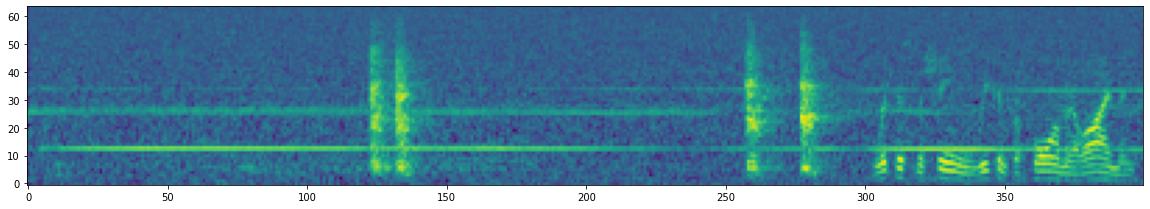

In [44]:
plt.figure(figsize = (20,10))
plt.imshow(noisy_gas_eval_x1[1].T, origin='lower')

In [47]:
result = []
batch_size =100
x = noisy_gas_eval_x1
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#         output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]

total num of batches during testing 202


In [48]:
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.14723834550599188 0.8145200613409921 1.265264082287105
 Average | 0.147 | 0.815 | 1.265 
---------+-------+-------+-------
       0 | 0.633 | 0.849 | 1.460 
       1 | 0.023 | 0.799 | 1.187 
       2 | 0.060 | 0.854 | 1.490 
       3 | 0.211 | 0.908 | 1.876 
       4 | 0.022 | 0.900 | 1.814 
       5 | 0.016 | 0.850 | 1.466 
       6 | 0.019 | 0.743 | 0.922 
       7 | 0.078 | 0.933 | 2.114 
       8 | 0.103 | 0.873 | 1.613 
       9 | 0.096 | 0.847 | 1.446 
      10 | 0.066 | 0.874 | 1.617 
      11 | 0.140 | 0.954 | 2.384 
      12 | 0.697 | 0.996 | 3.750 
      13 | 0.426 | 0.988 | 3.214 
      14 | 0.099 | 0.920 | 1.987 
      15 | 0.003 | 0.483 |-0.059 
      16 | 0.218 | 0.917 | 1.958 
      17 | 0.267 | 0.931 | 2.097 
      18 | 0.043 | 0.856 | 1.505 
      19 | 0.089 | 0.901 | 1.817 
      20 | 0.158 | 0.913 | 1.918 
      21 | 0.049 | 0.850 | 1.466 
      22 | 0.152 | 0.873 |